## Leaf count


Data source

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import random
import cv2 # for reading images

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# define the file locations
filesdir = '/content/drive/MyDrive/CVPPP2017/training/'
projdir = '/content/drive/MyDrive/CVPPP2017/'

In [4]:
# read the CSV file with the number of leafs
df = pd.read_csv(projdir+'A4.csv')
df

,file_name,leaves
0,plant0001_rgb.png,7
1,plant0002_rgb.png,7
2,plant0003_rgb.png,7
3,plant0004_rgb.png,6
4,plant0005_rgb.png,7
...,...,...
619,plant0843_rgb.png,28
620,plant0846_rgb.png,29
621,plant0848_rgb.png,27
622,plant0854_rgb.png,32


Show image examples from both categories

In [5]:
df.columns = [i.strip() for i in df.columns]
df

,file_name,leaves
0,plant0001_rgb.png,7
1,plant0002_rgb.png,7
2,plant0003_rgb.png,7
3,plant0004_rgb.png,6
4,plant0005_rgb.png,7
...,...,...
619,plant0843_rgb.png,28
620,plant0846_rgb.png,29
621,plant0848_rgb.png,27
622,plant0854_rgb.png,32


number of leaves:  6
<class 'numpy.ndarray'>
(441, 441, 3)
583443


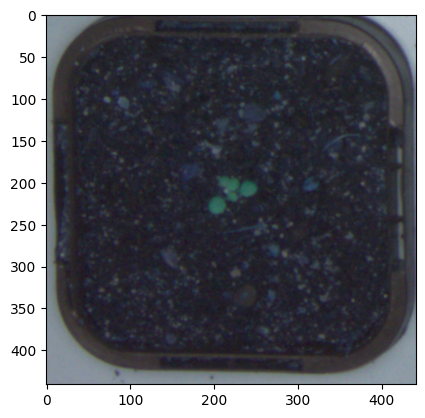

In [6]:
for img in os.listdir(filesdir):
    img_array = cv2.imread(os.path.join(filesdir,img))
    print('number of leaves: ', df.loc[df['file_name'] == img, 'leaves'].iloc[0])
    print(type(img_array))
    print(img_array.shape)
    print(img_array.size)
    plt.imshow(img_array)
    plt.show()
    break

In [7]:
# Specify the size of the images, also whether the images need to be processed into
# numpy arrays or have already been processes.
img_size = 100
files_saved = True

In [8]:
# train data
if not files_saved:
  training_data = []
  for img in os.listdir(filesdir):
    img_array = cv2.imread(os.path.join(filesdir,img))
    new_array = cv2.resize(img_array, (img_size, img_size))
    training_data.append([new_array, df.loc[df['file_name'] == img, 'leaves'].iloc[0]])
  #     print(f'=> importing {i} out of {num_images} images')
  # save files if it the the first time reading the data
  pickle.dump(training_data, open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/leaf_count/saved_files/training_data.pkl', "wb"))
else:
  training_data = pickle.load(open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/leaf_count/saved_files/training_data.pkl', "rb"))

In [9]:
# our data is structured in a list of list format, each list includes the image data
# and the number of leaves
len(training_data)

624

Create the train, validation, and test data. Use 20% of the training data for validation purposes.

In [10]:
# train data
random.shuffle(training_data)
X = []
y = []
for features, counts in training_data:
    X.append(features)
    y.append(counts)
X_train = np.array(X[:500]).reshape(-1, img_size, img_size, 3)
y_train = np.array(y[:500])
print('train data shape')
print(X_train.shape)
print(y_train.shape)
# validation data
X_val = np.array(X[500:]).reshape(-1, img_size, img_size, 3)
y_val = np.array(y[500:])
print('val data shape')
print(X_val.shape)
print(y_val.shape)

train data shape
(500, 100, 100, 3)
(500,)
val data shape
(124, 100, 100, 3)
(124,)


Build the CNN model from scratch. We will use data augmentation to help with overfitting. Additional layers are used when needed.

In [14]:
# build the model using Keras API's
# data augmentation
# data_augmentation = keras.Sequential([
#     layers.RandomFlip('horizontal'),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.2)
# ])

inputs = keras.Input(shape=(img_size, img_size, 3))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae')

history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size = 256,
                    epochs = 100)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                      

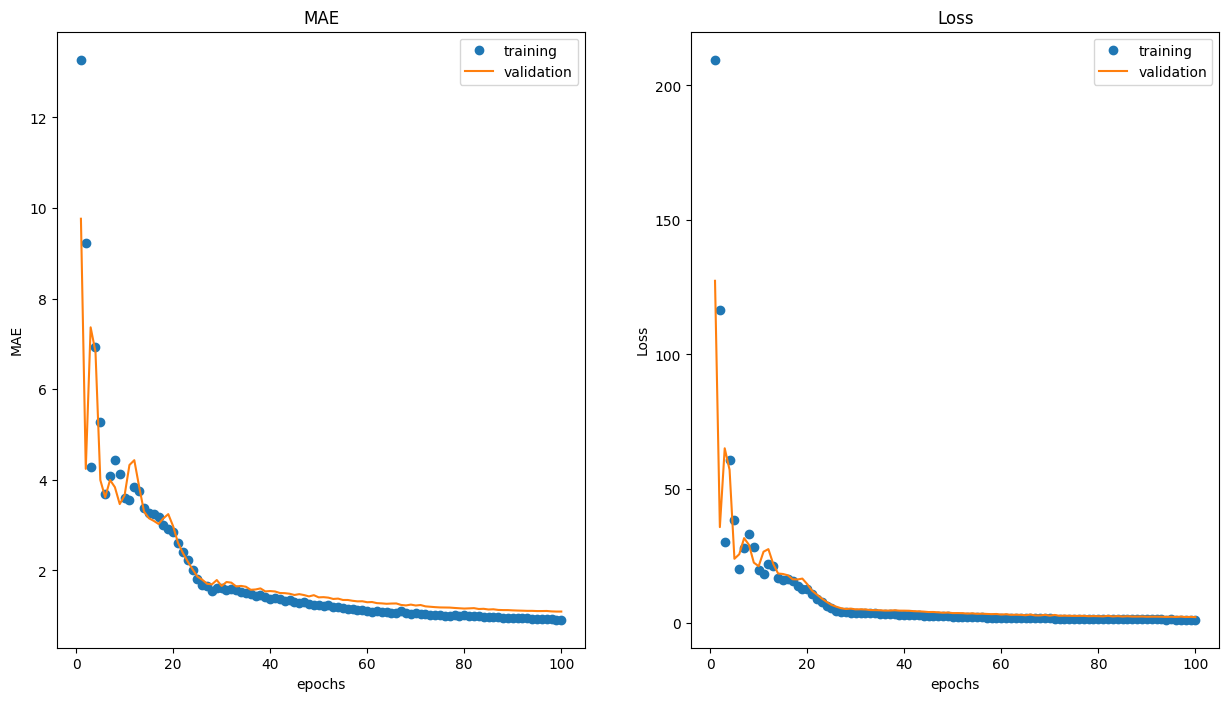

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 8))
axes[0].plot(range(1,len(history.history['mae'])+1), history.history['mae'], marker='o', linestyle= '', label='training')
axes[0].plot(range(1,len(history.history['mae'])+1), history.history['val_mae'], label='validation')
axes[0].set_title('MAE')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('MAE')
axes[0].legend()
axes[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'], marker='o', linestyle= '', label='training')
axes[1].plot(range(1,len(history.history['loss'])+1), history.history['val_loss'], label='validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [ ]:
# to evaluate the model on the test data
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 1s 72ms/step - loss: 0.1932 - acc: 0.9307
test loss, test acc: [0.19319383800029755, 0.930708646774292]
